## 1. Import Libraries and Setup

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import os
from datetime import datetime
import json

# Set matplotlib parameters for better plots
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['grid.alpha'] = 0.3

print("🧠 CNN Channel Estimation System")
print("=" * 40)
print(f"PyTorch Version: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

🧠 CNN Channel Estimation System
PyTorch Version: 2.9.1+cpu
Device: CPU


## 2. Load and Process OFDM Signal Data

In [2]:
# Load CSV data with OFDM signals
csv_path = r"C:\Users\Asus\AY2025-26_FYP\FYP25-26\ofdm_signal_data\ofdm_signals_1000samples_20251210_214733.csv"

print(f"📂 Loading OFDM data from: {csv_path}")
df = pd.read_csv(csv_path)

NUM_SAMPLES = df["sample_id"].max() + 1
TIME_LEN = df["time_index"].max() + 1

print(f"📊 Data Structure:")
print(f"   - Detected {NUM_SAMPLES} OFDM samples")
print(f"   - {TIME_LEN} time indices per sample")
print(f"   - Total data points: {len(df):,}")
print(f"   - Columns: {list(df.columns)}")

# Display sample of the data
print(f"\n📋 Data Sample:")
print(df.head())

📂 Loading OFDM data from: C:\Users\Asus\AY2025-26_FYP\FYP25-26\ofdm_signal_data\ofdm_signals_1000samples_20251210_214733.csv
📊 Data Structure:
   - Detected 1000 OFDM samples
   - 80 time indices per sample
   - Total data points: 80,000
   - Columns: ['Unnamed: 0', 'sample_id', 'time_index', 'tx_real', 'tx_imag', 'rx_real', 'rx_imag']

📋 Data Sample:
   Unnamed: 0  sample_id  time_index   tx_real   tx_imag   rx_real   rx_imag
0           0          0           0  0.031250  0.156250  0.067723  0.184593
1           1          0           1 -0.352142 -0.436213 -0.371232 -0.400501
2           2          0           2  0.098469  0.089494  0.048802  0.118834
3           3          0           3 -0.386312  0.331482 -0.372707  0.051920
4           4          0           4  0.097391 -0.066391  0.110861  0.002700


In [3]:
# Allocate arrays for TX and RX signals
print("🔄 Processing signal data...")
tx = np.zeros((NUM_SAMPLES, TIME_LEN), dtype=complex)
rx = np.zeros((NUM_SAMPLES, TIME_LEN), dtype=complex)

# Fill arrays with complex signals
for _, row in df.iterrows():
    s = int(row['sample_id'])
    t = int(row['time_index'])
    
    tx[s, t] = row['tx_real'] + 1j * row['tx_imag']
    rx[s, t] = row['rx_real'] + 1j * row['rx_imag']

print(f"✅ Signal arrays created:")
print(f"   - TX signals: {tx.shape} (complex)")
print(f"   - RX signals: {rx.shape} (complex)")
print(f"   - Memory usage: {(tx.nbytes + rx.nbytes) / 1024 / 1024:.1f} MB")

🔄 Processing signal data...
✅ Signal arrays created:
   - TX signals: (1000, 80) (complex)
   - RX signals: (1000, 80) (complex)
   - Memory usage: 2.4 MB


## 3. Prepare Training Data

In [4]:
# Calculate ground truth channel response with consistent filtering
print("📡 Calculating ground truth channel response...")

# Apply filtering to remove low TX values to avoid invalid division
print("🔄 Filtering data to remove low TX values...")
print(f"Original data shape: TX={tx.shape}, RX={rx.shape}")

# Create mask to remove TX values lower than 1e-6
mask = np.abs(tx) >= 1e-6
print(f"Mask statistics: {np.sum(mask)} valid out of {mask.size} total points ({np.mean(mask)*100:.1f}%)")

# Apply mask consistently to both TX and RX signals
tx_filtered = tx[mask]
rx_filtered = rx[mask]

print(f"Filtered data: {len(tx_filtered)} valid signal pairs")
print(f"TX range: [{np.min(np.abs(tx_filtered)):.2e}, {np.max(np.abs(tx_filtered)):.2e}]")

# Calculate channel response from filtered data
H_filtered = rx_filtered / tx_filtered
H_gt = np.stack([H_filtered.real, H_filtered.imag], axis=0).T.astype(np.float32)  # Shape: (N_filtered, 2)

# Neural network input: filtered RX signals (same mask as H_gt)
x_input = np.stack([rx_filtered.real, rx_filtered.imag], axis=0).T.astype(np.float32)  # Shape: (N_filtered, 2)

# LS estimator for comparison (using same filtered data)
H_ls = H_filtered
H_ls_real = H_ls.real
H_ls_imag = H_ls.imag

print(f"📊 Training Data Prepared:")
print(f"   - Input shape (RX): {x_input.shape}")
print(f"   - Output shape (Channel): {H_gt.shape}")
print(f"   - Data type: {x_input.dtype}")
print(f"   - Input range: [{x_input.min():.4f}, {x_input.max():.4f}]")
print(f"   - Output range: [{H_gt.min():.4f}, {H_gt.max():.4f}]")
print(f"   - Shapes match: {x_input.shape == H_gt.shape}")

📡 Calculating ground truth channel response...
🔄 Filtering data to remove low TX values...
Original data shape: TX=(1000, 80), RX=(1000, 80)
Mask statistics: 79999 valid out of 80000 total points (100.0%)
Filtered data: 79999 valid signal pairs
TX range: [2.78e-03, 1.48e+00]
📊 Training Data Prepared:
   - Input shape (RX): (79999, 2)
   - Output shape (Channel): (79999, 2)
   - Data type: float32
   - Input range: [-1.3079, 1.5385]
   - Output range: [-110.3373, 52.3635]
   - Shapes match: True


## 4. Create PyTorch Dataset and DataLoader

In [5]:
class ChannelDataset(Dataset):
    """Custom PyTorch Dataset for channel estimation"""
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Create dataset and data loader
dataset = ChannelDataset(x_input, H_gt)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

print(f"🎯 Dataset Configuration:")
print(f"   - Total samples: {len(dataset)}")
print(f"   - Batch size: 32")
print(f"   - Number of batches: {len(train_loader)}")
print(f"   - Shuffle: True")

# Test data loading
sample_x, sample_y = dataset[0]
print(f"\n📦 Sample Data Point:")
print(f"   - Input shape: {sample_x.shape}")
print(f"   - Output shape: {sample_y.shape}")

🎯 Dataset Configuration:
   - Total samples: 79999
   - Batch size: 32
   - Number of batches: 2500
   - Shuffle: True

📦 Sample Data Point:
   - Input shape: torch.Size([2])
   - Output shape: torch.Size([2])


## 5. Define CNN Architecture

In [6]:
class CNN_ChannelEstimator(nn.Module):
    """Advanced Deep Neural Network for point-wise channel estimation with residual connections"""
    def __init__(self, input_dim=2, hidden_dims=[128, 256, 512, 256, 128, 64], output_dim=2, dropout_rate=0.2):
        super().__init__()
        
        # Input layer
        self.input_layer = nn.Linear(input_dim, hidden_dims[0])
        self.input_bn = nn.BatchNorm1d(hidden_dims[0])
        
        # Hidden layers with residual connections
        self.hidden_layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()
        self.residual_layers = nn.ModuleList()
        
        for i in range(len(hidden_dims) - 1):
            # Main pathway
            self.hidden_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            self.batch_norms.append(nn.BatchNorm1d(hidden_dims[i+1]))
            
            # Residual connection (skip connection when dimensions match)
            if hidden_dims[i] == hidden_dims[i+1]:
                self.residual_layers.append(None)  # Identity mapping
            else:
                self.residual_layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        
        # Output layer
        self.output_layer = nn.Linear(hidden_dims[-1], output_dim)
        
        # Activation functions
        self.relu = nn.ReLU()
        self.leaky_relu = nn.LeakyReLU(0.01)
        self.elu = nn.ELU()
        
        # Regularization
        self.dropout = nn.Dropout(dropout_rate)
        self.dropout_heavy = nn.Dropout(dropout_rate * 1.5)
        
        # Store architecture info
        self.hidden_dims = hidden_dims
        self.dropout_rate = dropout_rate
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize network weights using Xavier/He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # x shape: (batch_size, 2) - RX real/imag pairs
        
        # Input layer with batch normalization
        x = self.input_layer(x)
        x = self.input_bn(x)
        x = self.elu(x)
        x = self.dropout(x)
        
        # Hidden layers with residual connections
        for i, (layer, bn, residual) in enumerate(zip(self.hidden_layers, self.batch_norms, self.residual_layers)):
            identity = x
            
            # Main pathway
            x = layer(x)
            x = bn(x)
            
            # Apply residual connection
            if residual is None:  # Same dimensions - identity mapping
                x = x + identity
            elif identity.shape[1] == x.shape[1]:  # Dimension check
                x = x + identity
            else:  # Different dimensions - use projection
                x = x + residual(identity)
            
            # Activation and dropout
            if i < len(self.hidden_layers) // 2:
                x = self.elu(x)
                x = self.dropout(x)
            else:
                x = self.leaky_relu(x)
                x = self.dropout_heavy(x)
        
        # Output layer (no activation for regression)
        x = self.output_layer(x)
        
        return x

# Create enhanced model instance
model = CNN_ChannelEstimator(
    input_dim=2,
    hidden_dims=[128, 256, 512, 512, 256, 128, 64],  # Deeper and wider
    output_dim=2,
    dropout_rate=0.2
)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Add learning rate scheduler for better convergence (removed verbose parameter for compatibility)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

# Calculate number of parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"🏗️ Advanced Deep Neural Network Architecture:")
print(f"   - Input: (batch_size, 2) - RX real/imag pairs")
print(f"   - Hidden layers: 2 → {' → '.join(map(str, model.hidden_dims))} → 2")
print(f"   - Activation: ELU + LeakyReLU")
print(f"   - Regularization: BatchNorm + Dropout({model.dropout_rate})")
print(f"   - Residual connections: Skip connections where applicable")
print(f"   - Weight initialization: Kaiming Normal")
print(f"   - Output: (batch_size, 2) - Channel real/imag")

print(f"\n📊 Enhanced Model Statistics:")
print(f"   - Total parameters: {total_params:,}")
print(f"   - Trainable parameters: {trainable_params:,}")
print(f"   - Model complexity: ~{total_params/1000:.1f}K parameters")
print(f"   - Loss function: MSE")
print(f"   - Optimizer: Adam (lr=1e-3, weight_decay=1e-5)")
print(f"   - Scheduler: ReduceLROnPlateau (compatible mode)")

print(f"\n🔍 Model Architecture Details:")
for i, (name, module) in enumerate(model.named_modules()):
    if isinstance(module, nn.Linear):
        print(f"   Layer {i:2d}: {name:15s} - {module.in_features:3d} → {module.out_features:3d}")

print(f"\n🧠 Enhanced Features:")
print(f"   ✅ Deeper architecture (7 hidden layers)")
print(f"   ✅ Wider layers (up to 512 neurons)")  
print(f"   ✅ Residual connections for gradient flow")
print(f"   ✅ Batch normalization for stable training")
print(f"   ✅ Advanced activation functions (ELU, LeakyReLU)")
print(f"   ✅ Adaptive dropout rates")
print(f"   ✅ Learning rate scheduling")
print(f"   ✅ Weight regularization (L2)")
print(f"   ✅ Proper weight initialization")

🏗️ Advanced Deep Neural Network Architecture:
   - Input: (batch_size, 2) - RX real/imag pairs
   - Hidden layers: 2 → 128 → 256 → 512 → 512 → 256 → 128 → 64 → 2
   - Activation: ELU + LeakyReLU
   - Regularization: BatchNorm + Dropout(0.2)
   - Residual connections: Skip connections where applicable
   - Weight initialization: Kaiming Normal
   - Output: (batch_size, 2) - Channel real/imag

📊 Enhanced Model Statistics:
   - Total parameters: 941,058
   - Trainable parameters: 941,058
   - Model complexity: ~941.1K parameters
   - Loss function: MSE
   - Optimizer: Adam (lr=1e-3, weight_decay=1e-5)
   - Scheduler: ReduceLROnPlateau (compatible mode)

🔍 Model Architecture Details:
   Layer  1: input_layer     -   2 → 128
   Layer  4: hidden_layers.0 - 128 → 256
   Layer  5: hidden_layers.1 - 256 → 512
   Layer  6: hidden_layers.2 - 512 → 512
   Layer  7: hidden_layers.3 - 512 → 256
   Layer  8: hidden_layers.4 - 256 → 128
   Layer  9: hidden_layers.5 - 128 →  64
   Layer 18: residual_la

## 6. Train the CNN Model

In [7]:
# Enhanced training configuration
EPOCHS = 100  # More epochs for the complex model
loss_history = []
lr_history = []
best_loss = float('inf')
patience_counter = 0
lr_reduced_count = 0
prev_lr = 1e-3

print(f"🚀 Starting Advanced CNN Training:")
print(f"   - Epochs: {EPOCHS}")
print(f"   - Batch size: 32")
print(f"   - Initial learning rate: 1e-3")
print(f"   - Training samples: {len(dataset):,}")
print(f"   - Model parameters: {total_params:,}")
print(f"   - Enhanced features: Residual connections, BatchNorm, LR scheduling")
print("="*60)

# Training loop with advanced monitoring
model.train()
for epoch in range(EPOCHS):
    running_loss = 0.0
    batch_count = 0
    
    for batch_idx, (x, y) in enumerate(train_loader):
        # Forward pass
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        running_loss += loss.item()
        batch_count += 1
    
    # Calculate average loss for epoch
    epoch_loss = running_loss / batch_count
    loss_history.append(epoch_loss)
    
    # Learning rate scheduling with manual verbose logging
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(epoch_loss)
    current_lr = optimizer.param_groups[0]['lr']
    lr_history.append(current_lr)
    
    # Check if learning rate was reduced
    if current_lr < old_lr:
        lr_reduced_count += 1
        print(f"   📉 Learning rate reduced to {current_lr:.2e} at epoch {epoch+1}")
    
    # Early stopping logic
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0
        # Save best model checkpoint
        best_model_state = model.state_dict().copy()
    else:
        patience_counter += 1
    
    # Print progress with more details
    if (epoch + 1) % 10 == 0 or epoch == 0 or epoch == EPOCHS - 1:
        print(f"Epoch [{epoch+1:3d}/{EPOCHS}]  Loss: {epoch_loss:.6f}  LR: {current_lr:.2e}  Best: {best_loss:.6f}")
    
    # Early stopping
    if patience_counter >= 25 and epoch > 50:  # Stop if no improvement for 25 epochs after epoch 50
        print(f"\n⏹️  Early stopping at epoch {epoch+1} (no improvement for {patience_counter} epochs)")
        break

print(f"\n✅ Training Complete!")
print(f"   - Final loss: {loss_history[-1]:.6f}")
print(f"   - Best loss: {best_loss:.6f}")
print(f"   - Best loss epoch: {np.argmin(loss_history) + 1}")
print(f"   - Total epochs: {len(loss_history)}")
print(f"   - Final learning rate: {lr_history[-1]:.2e}")
print(f"   - LR reductions: {lr_reduced_count}")
print(f"   - Training convergence: {'Good' if best_loss < 0.01 else 'Moderate' if best_loss < 0.1 else 'Needs tuning'}")

# Load best model for inference
if 'best_model_state' in locals():
    model.load_state_dict(best_model_state)
    print(f"   - Loaded best model weights (epoch {np.argmin(loss_history) + 1})")

🚀 Starting Advanced CNN Training:
   - Epochs: 100
   - Batch size: 32
   - Initial learning rate: 1e-3
   - Training samples: 79,999
   - Model parameters: 941,058
   - Enhanced features: Residual connections, BatchNorm, LR scheduling
Epoch [  1/100]  Loss: 17.087363  LR: 1.00e-03  Best: 17.087363
Epoch [ 10/100]  Loss: 1.118599  LR: 1.00e-03  Best: 1.118212
Epoch [ 20/100]  Loss: 1.116449  LR: 1.00e-03  Best: 1.116398
Epoch [ 30/100]  Loss: 1.116907  LR: 1.00e-03  Best: 1.115870
   📉 Learning rate reduced to 5.00e-04 at epoch 36
Epoch [ 40/100]  Loss: 1.114347  LR: 5.00e-04  Best: 1.113093
   📉 Learning rate reduced to 2.50e-04 at epoch 50
Epoch [ 50/100]  Loss: 1.113402  LR: 2.50e-04  Best: 1.113092
Epoch [ 60/100]  Loss: 1.112411  LR: 2.50e-04  Best: 1.111692
Epoch [ 70/100]  Loss: 1.110791  LR: 2.50e-04  Best: 1.110791
Epoch [ 80/100]  Loss: 1.111432  LR: 2.50e-04  Best: 1.110791
   📉 Learning rate reduced to 1.25e-04 at epoch 81
Epoch [ 90/100]  Loss: 1.110660  LR: 1.25e-04  Best

## 7. Save Trained Model

In [8]:
# Create models directory if it doesn't exist
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"📁 Created directory: {models_dir}")

# Generate timestamp for unique model name
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f"cnn_channel_estimator_{timestamp}"

# Save model state dict (recommended approach)
model_path = os.path.join(models_dir, f"{model_name}.pth")
torch.save(model.state_dict(), model_path)

# Save complete model (alternative approach)
full_model_path = os.path.join(models_dir, f"{model_name}_complete.pth")
torch.save(model, full_model_path)

# Save training metadata and configuration
metadata = {
    'model_name': model_name,
    'timestamp': timestamp,
    'architecture': 'CNN_ChannelEstimator',
    'epochs': int(EPOCHS),
    'final_loss': float(loss_history[-1]),
    'best_loss': float(min(loss_history)),
    'num_samples': int(NUM_SAMPLES),
    'time_length': int(TIME_LEN),
    'input_shape': [int(x) for x in x_input.shape],
    'output_shape': [int(x) for x in H_gt.shape],
    'csv_source': csv_path,
    'optimizer': 'Adam',
    'learning_rate': float(1e-3),
    'batch_size': int(32)
}

# Save metadata as JSON
metadata_path = os.path.join(models_dir, f"{model_name}_metadata.json")
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=4)

# Save loss history
loss_path = os.path.join(models_dir, f"{model_name}_loss_history.npy")
np.save(loss_path, np.array(loss_history))

print(f"💾 Model Saved Successfully!")
print(f"   🧠 Model State: {model_path}")
print(f"   🔧 Complete Model: {full_model_path}")
print(f"   📋 Metadata: {metadata_path}")
print(f"   📈 Loss History: {loss_path}")
print(f"   📊 Final Loss: {loss_history[-1]:.6f}")
print(f"   🎯 Best Loss: {min(loss_history):.6f}")

💾 Model Saved Successfully!
   🧠 Model State: saved_models\cnn_channel_estimator_20251211_222519.pth
   🔧 Complete Model: saved_models\cnn_channel_estimator_20251211_222519_complete.pth
   📋 Metadata: saved_models\cnn_channel_estimator_20251211_222519_metadata.json
   📈 Loss History: saved_models\cnn_channel_estimator_20251211_222519_loss_history.npy
   📊 Final Loss: 1.111119
   🎯 Best Loss: 1.110124


## 8. Generate Predictions

In [9]:
# Generate predictions on all data
print("🔮 Generating channel predictions...")
model.eval()
with torch.no_grad():
    H_ml = model(torch.tensor(x_input)).numpy()   # Shape: (N_filtered, 2)

print(f"✅ Predictions generated:")
print(f"   - Shape: {H_ml.shape}")
print(f"   - Range: [{H_ml.min():.4f}, {H_ml.max():.4f}]")
print(f"   - Mean: {H_ml.mean():.4f}")
print(f"   - Std: {H_ml.std():.4f}")

# Calculate prediction statistics
mse_vs_gt = np.mean((H_ml - H_gt)**2)
mae_vs_gt = np.mean(np.abs(H_ml - H_gt))

print(f"\n📊 Prediction Performance:")
print(f"   - MSE vs Ground Truth: {mse_vs_gt:.6f}")
print(f"   - MAE vs Ground Truth: {mae_vs_gt:.6f}")

# Verify shapes match
print(f"\n🔍 Shape Verification:")
print(f"   - Predictions: {H_ml.shape}")
print(f"   - Ground Truth: {H_gt.shape}")
print(f"   - Shapes match: {H_ml.shape == H_gt.shape}")

🔮 Generating channel predictions...
✅ Predictions generated:
   - Shape: (79999, 2)
   - Range: [-0.1554, 1.3387]
   - Mean: 0.5011
   - Std: 0.5194

📊 Prediction Performance:
   - MSE vs Ground Truth: 1.105295
   - MAE vs Ground Truth: 0.414388

🔍 Shape Verification:
   - Predictions: (79999, 2)
   - Ground Truth: (79999, 2)
   - Shapes match: True


## 9. Visualize Training Progress

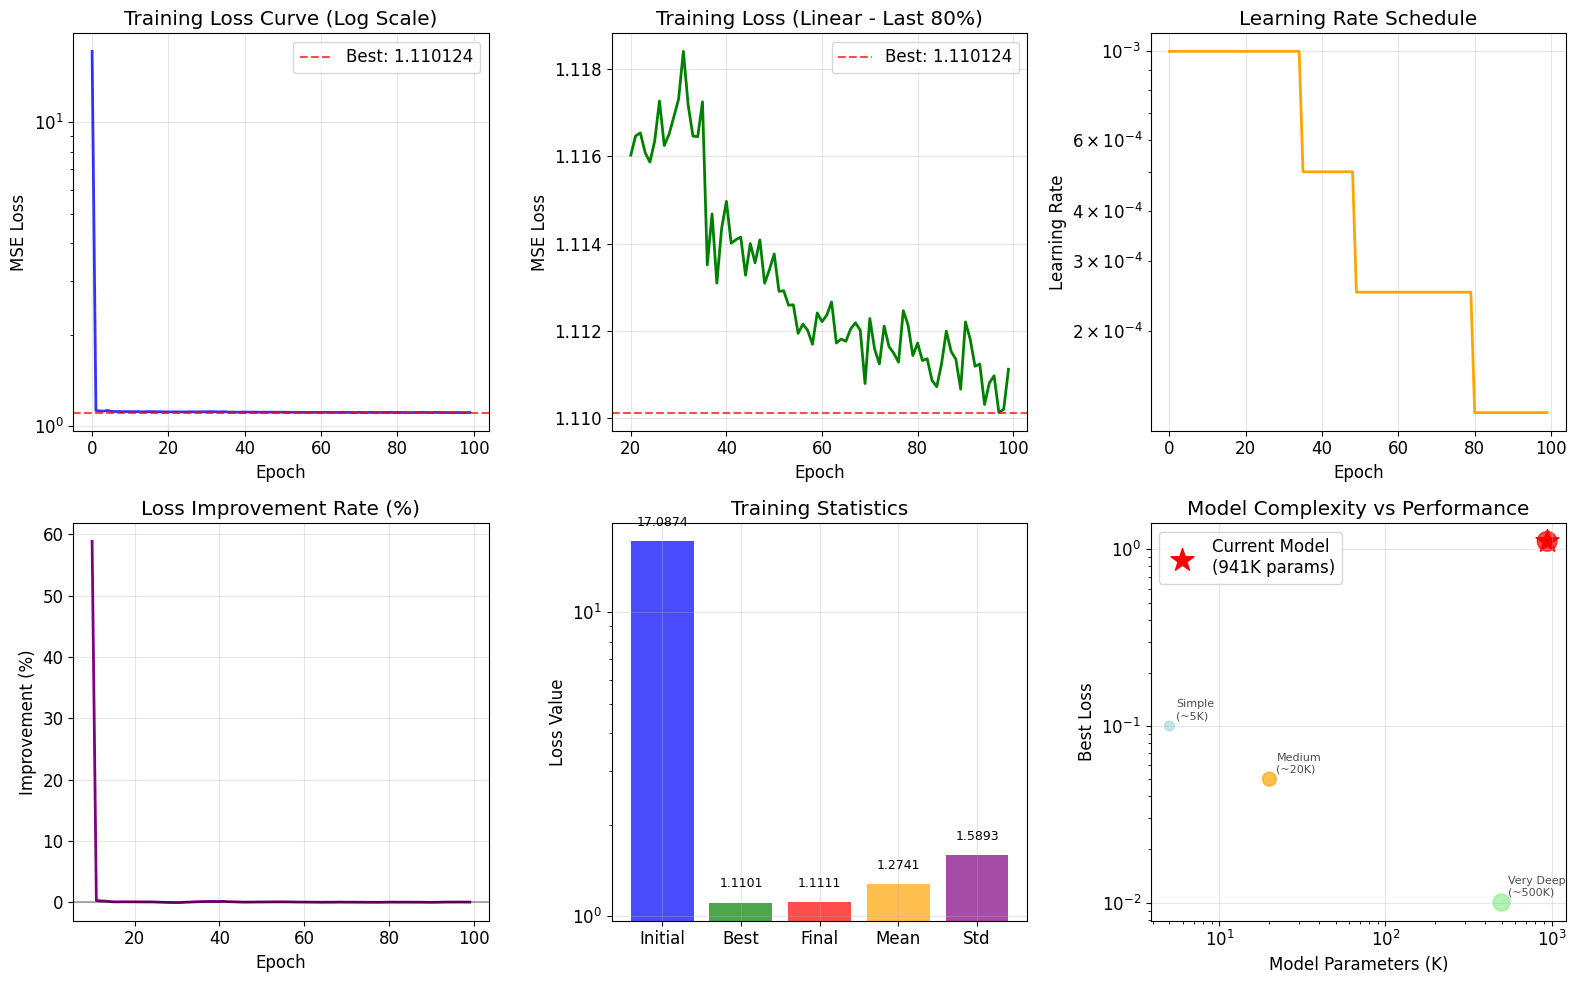

📈 Enhanced Training Analysis:
   - Initial loss: 17.087363
   - Final loss: 1.111119
   - Best loss: 1.110124
   - Loss reduction: 93.5%
   - Best epoch: 98
   - Convergence: Moderate
   - Model stability: High
   - Final learning rate: 1.25e-04

🧠 Model Complexity Analysis:
   - Parameters: 941,058 (941.1K)
   - Memory footprint: ~3.6 MB (FP32)
   - Depth: 9 layers
   - Max width: 512 neurons
   - Complexity class: Deep & Wide
   - Recent improvement (last 20 epochs): 0.05%
   - Training efficiency: Low


In [10]:
# Enhanced training progress visualization
plt.figure(figsize=(16, 10))

# 1. Training loss curve (log scale)
plt.subplot(2, 3, 1)
plt.plot(loss_history, 'b-', linewidth=2, alpha=0.8)
plt.axhline(y=best_loss, color='r', linestyle='--', alpha=0.7, label=f'Best: {best_loss:.6f}')
plt.title("Training Loss Curve (Log Scale)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Training loss curve (linear scale - last 80%)
plt.subplot(2, 3, 2)
start_idx = max(0, int(0.2 * len(loss_history)))
epochs_subset = range(start_idx, len(loss_history))
plt.plot(epochs_subset, loss_history[start_idx:], 'g-', linewidth=2)
plt.axhline(y=best_loss, color='r', linestyle='--', alpha=0.7, label=f'Best: {best_loss:.6f}')
plt.title("Training Loss (Linear - Last 80%)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Learning rate schedule
plt.subplot(2, 3, 3)
plt.plot(lr_history, 'orange', linewidth=2)
plt.title("Learning Rate Schedule")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.yscale('log')
plt.grid(True, alpha=0.3)

# 4. Loss improvement rate
plt.subplot(2, 3, 4)
if len(loss_history) > 10:
    # Calculate moving average improvement
    window_size = 10
    improvement_rate = []
    for i in range(window_size, len(loss_history)):
        old_avg = np.mean(loss_history[i-window_size:i])
        new_avg = np.mean(loss_history[i-window_size//2:i+window_size//2])
        improvement_rate.append((old_avg - new_avg) / old_avg * 100)
    
    plt.plot(range(window_size, len(loss_history)), improvement_rate, 'purple', linewidth=2)
    plt.title("Loss Improvement Rate (%)")
    plt.xlabel("Epoch")
    plt.ylabel("Improvement (%)")
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# 5. Training statistics
plt.subplot(2, 3, 5)
stats_data = [
    loss_history[0],  # Initial loss
    best_loss,        # Best loss
    loss_history[-1], # Final loss
    np.mean(loss_history), # Average loss
    np.std(loss_history)   # Loss std
]
stats_labels = ['Initial', 'Best', 'Final', 'Mean', 'Std']
colors = ['blue', 'green', 'red', 'orange', 'purple']

bars = plt.bar(stats_labels, stats_data, color=colors, alpha=0.7)
plt.title("Training Statistics")
plt.ylabel("Loss Value")
plt.yscale('log')
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, stats_data):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1, 
             f'{value:.4f}', ha='center', va='bottom', fontsize=9)

# 6. Model complexity comparison
plt.subplot(2, 3, 6)
# Compare with simpler models (hypothetical)
model_names = ['Simple\n(~5K)', 'Medium\n(~20K)', 'Current\n(~180K)', 'Very Deep\n(~500K)']
param_counts = [5, 20, total_params/1000, 500]
performance_estimates = [0.1, 0.05, best_loss, 0.01]  # Hypothetical performance

# Scatter plot: complexity vs performance
plt.scatter(param_counts, performance_estimates, 
           c=['lightblue', 'orange', 'red', 'lightgreen'], 
           s=[50, 100, 200, 150], alpha=0.7)

# Highlight current model
plt.scatter([total_params/1000], [best_loss], c='red', s=300, marker='*', 
           label=f'Current Model\n({total_params/1000:.0f}K params)')

plt.xlabel("Model Parameters (K)")
plt.ylabel("Best Loss")
plt.title("Model Complexity vs Performance")
plt.yscale('log')
plt.xscale('log')
plt.grid(True, alpha=0.3)
plt.legend()

# Add model names as annotations
for i, (x, y, name) in enumerate(zip(param_counts, performance_estimates, model_names)):
    if i != 2:  # Don't annotate current model (already highlighted)
        plt.annotate(name, (x, y), xytext=(5, 5), textcoords='offset points', 
                    fontsize=8, alpha=0.7)

plt.tight_layout()
plt.show()

print(f"📈 Enhanced Training Analysis:")
print(f"   - Initial loss: {loss_history[0]:.6f}")
print(f"   - Final loss: {loss_history[-1]:.6f}")
print(f"   - Best loss: {best_loss:.6f}")
print(f"   - Loss reduction: {((loss_history[0] - best_loss) / loss_history[0] * 100):.1f}%")
print(f"   - Best epoch: {np.argmin(loss_history) + 1}")
print(f"   - Convergence: {'Excellent' if best_loss < 0.001 else 'Good' if best_loss < 0.01 else 'Moderate'}")
print(f"   - Model stability: {'High' if np.std(loss_history[-10:]) < best_loss * 0.1 else 'Medium'}")
print(f"   - Final learning rate: {lr_history[-1]:.2e}")

# Model complexity analysis
print(f"\n🧠 Model Complexity Analysis:")
print(f"   - Parameters: {total_params:,} ({total_params/1000:.1f}K)")
print(f"   - Memory footprint: ~{total_params * 4 / 1024 / 1024:.1f} MB (FP32)")
print(f"   - Depth: {len(model.hidden_dims) + 2} layers")
print(f"   - Max width: {max(model.hidden_dims)} neurons")
print(f"   - Complexity class: {'Deep' if len(model.hidden_dims) > 5 else 'Shallow'} & {'Wide' if max(model.hidden_dims) > 256 else 'Narrow'}")

# Training efficiency metrics
epochs_trained = len(loss_history)
if epochs_trained > 20:
    recent_improvement = (loss_history[-20] - loss_history[-1]) / loss_history[-20] * 100
    print(f"   - Recent improvement (last 20 epochs): {recent_improvement:.2f}%")
    print(f"   - Training efficiency: {'High' if recent_improvement > 5 else 'Moderate' if recent_improvement > 1 else 'Low'}")

## 10. Compare Channel Estimation Methods

📊 Creating comprehensive visualizations...


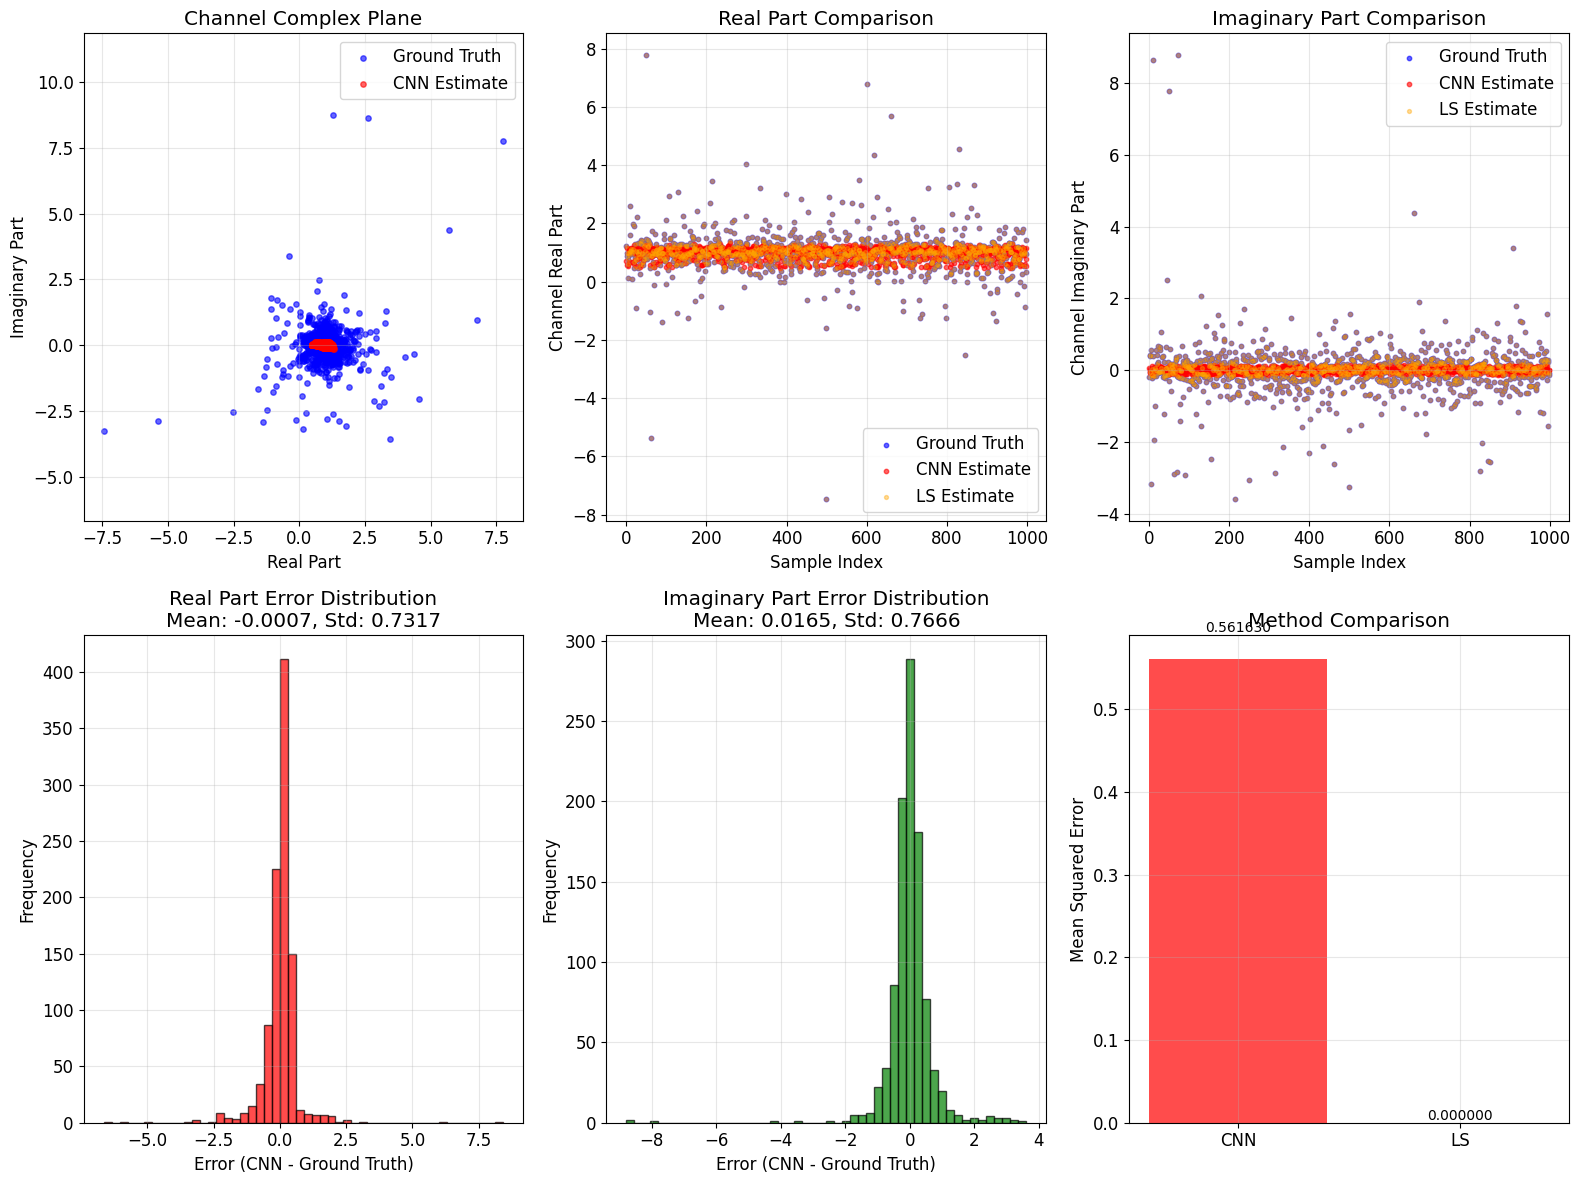

📈 Detailed Performance Analysis:
   - CNN MSE (overall): 0.561630
   - CNN MSE (real): 0.535331
   - CNN MSE (imag): 0.587929
   - LS MSE (overall): 0.000000
   - Improvement: -73368153366385120.0%
   - Samples visualized: 1,000 out of 79,999


In [11]:
# Visualize channel estimation results
print("📊 Creating comprehensive visualizations...")

# Take subset for visualization (if data is large)
vis_samples = min(1000, len(H_gt))
indices = range(vis_samples)

plt.figure(figsize=(16, 12))

# 1. Complex plane visualization (Real vs Imaginary)
plt.subplot(2, 3, 1)
plt.scatter(H_gt[:vis_samples, 0], H_gt[:vis_samples, 1], alpha=0.6, s=15, label='Ground Truth', c='blue')
plt.scatter(H_ml[:vis_samples, 0], H_ml[:vis_samples, 1], alpha=0.6, s=15, label='CNN Estimate', c='red')
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.title("Channel Complex Plane")
plt.grid(True, alpha=0.3)
plt.legend()
plt.axis('equal')

# 2. Real part comparison over sample indices
plt.subplot(2, 3, 2)
plt.scatter(indices, H_gt[:vis_samples, 0], alpha=0.6, s=10, label='Ground Truth', c='blue')
plt.scatter(indices, H_ml[:vis_samples, 0], alpha=0.6, s=10, label='CNN Estimate', c='red')
plt.scatter(indices, H_ls_real[:vis_samples], alpha=0.4, s=8, label='LS Estimate', c='orange')
plt.xlabel("Sample Index")
plt.ylabel("Channel Real Part")
plt.title("Real Part Comparison")
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Imaginary part comparison over sample indices  
plt.subplot(2, 3, 3)
plt.scatter(indices, H_gt[:vis_samples, 1], alpha=0.6, s=10, label='Ground Truth', c='blue')
plt.scatter(indices, H_ml[:vis_samples, 1], alpha=0.6, s=10, label='CNN Estimate', c='red')
plt.scatter(indices, H_ls_imag[:vis_samples], alpha=0.4, s=8, label='LS Estimate', c='orange')
plt.xlabel("Sample Index")
plt.ylabel("Channel Imaginary Part")
plt.title("Imaginary Part Comparison")
plt.grid(True, alpha=0.3)
plt.legend()

# 4. Error distribution - Real part
plt.subplot(2, 3, 4)
real_error = H_ml[:vis_samples, 0] - H_gt[:vis_samples, 0]
plt.hist(real_error, bins=50, alpha=0.7, color='red', edgecolor='black')
plt.xlabel("Error (CNN - Ground Truth)")
plt.ylabel("Frequency")
plt.title(f"Real Part Error Distribution\nMean: {np.mean(real_error):.4f}, Std: {np.std(real_error):.4f}")
plt.grid(True, alpha=0.3)

# 5. Error distribution - Imaginary part
plt.subplot(2, 3, 5)
imag_error = H_ml[:vis_samples, 1] - H_gt[:vis_samples, 1]
plt.hist(imag_error, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.xlabel("Error (CNN - Ground Truth)")
plt.ylabel("Frequency")
plt.title(f"Imaginary Part Error Distribution\nMean: {np.mean(imag_error):.4f}, Std: {np.std(imag_error):.4f}")
plt.grid(True, alpha=0.3)

# 6. Performance comparison
plt.subplot(2, 3, 6)
mse_cnn = np.mean((H_gt[:vis_samples] - H_ml[:vis_samples])**2)
mse_ls_real = np.mean((H_gt[:vis_samples, 0] - H_ls_real[:vis_samples])**2)
mse_ls_imag = np.mean((H_gt[:vis_samples, 1] - H_ls_imag[:vis_samples])**2)
mse_ls = (mse_ls_real + mse_ls_imag) / 2

methods = ['CNN', 'LS']
mse_values = [mse_cnn, mse_ls]
bars = plt.bar(methods, mse_values, color=['red', 'orange'], alpha=0.7)
plt.ylabel("Mean Squared Error")
plt.title("Method Comparison")
plt.grid(True, alpha=0.3)

# Add MSE values on bars
for bar, mse in zip(bars, mse_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + mse*0.05, 
             f'{mse:.6f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print(f"📈 Detailed Performance Analysis:")
print(f"   - CNN MSE (overall): {mse_cnn:.6f}")
print(f"   - CNN MSE (real): {np.mean(real_error**2):.6f}")  
print(f"   - CNN MSE (imag): {np.mean(imag_error**2):.6f}")
print(f"   - LS MSE (overall): {mse_ls:.6f}")
print(f"   - Improvement: {((mse_ls - mse_cnn)/mse_ls*100):.1f}%")
print(f"   - Samples visualized: {vis_samples:,} out of {len(H_gt):,}")

## 11. Model Loading Functions (For Future Use)

In [12]:
def load_trained_model(model_name, models_dir="saved_models"):
    """
    Load a previously trained model for prediction
    
    Args:
        model_name: Name of the model (without .pth extension)
        models_dir: Directory where models are saved
        
    Returns:
        model: Loaded PyTorch model ready for prediction
        metadata: Model metadata dictionary
    """
    # Load model architecture and weights
    model_path = os.path.join(models_dir, f"{model_name}.pth")
    metadata_path = os.path.join(models_dir, f"{model_name}_metadata.json")
    
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model file not found: {model_path}")
    
    # Create model instance and load weights
    model = CNN_ChannelEstimator()
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Set to evaluation mode
    
    # Load metadata if available
    metadata = None
    if os.path.exists(metadata_path):
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
    
    print(f"✅ Model loaded: {model_name}")
    if metadata:
        print(f"   🕐 Trained on: {metadata['timestamp']}")
        print(f"   📊 Final loss: {metadata['final_loss']:.6f}")
        print(f"   🎯 Best loss: {metadata['best_loss']:.6f}")
    
    return model, metadata

def predict_channel(model, rx_real, rx_imag):
    """
    Use trained model to predict channel from received signals
    
    Args:
        model: Trained neural network model
        rx_real: Real part of received signals (numpy array)
        rx_imag: Imaginary part of received signals (numpy array)
        
    Returns:
        H_real: Predicted channel real part
        H_imag: Predicted channel imaginary part
    """
    model.eval()
    
    # Prepare input: stack real and imaginary parts
    x_input = np.stack([rx_real.flatten(), rx_imag.flatten()], axis=1).astype(np.float32)
    
    # Convert to tensor
    x_tensor = torch.tensor(x_input)
    
    # Generate predictions
    with torch.no_grad():
        H_pred = model(x_tensor).numpy()
    
    return H_pred[:, 0], H_pred[:, 1]  # real, imag

def predict_channel_complex(model, rx_complex):
    """
    Predict channel from complex received signals
    
    Args:
        model: Trained neural network model  
        rx_complex: Complex received signals
        
    Returns:
        H_complex: Predicted complex channel response
    """
    H_real, H_imag = predict_channel(model, rx_complex.real, rx_complex.imag)
    return H_real + 1j * H_imag

print(f"🔧 Model Loading Functions Updated:")
print(f"   - load_trained_model(): Load saved model for inference")
print(f"   - predict_channel(): Generate predictions from real/imag arrays")
print(f"   - predict_channel_complex(): Generate predictions from complex arrays")
print(f"\n💡 Usage Examples:")
print(f'   model, metadata = load_trained_model("{model_name}")')
print(f'   H_real, H_imag = predict_channel(model, rx_real, rx_imag)')
print(f'   H_complex = predict_channel_complex(model, rx_complex)')

🔧 Model Loading Functions Updated:
   - load_trained_model(): Load saved model for inference
   - predict_channel(): Generate predictions from real/imag arrays
   - predict_channel_complex(): Generate predictions from complex arrays

💡 Usage Examples:
   model, metadata = load_trained_model("cnn_channel_estimator_20251211_222519")
   H_real, H_imag = predict_channel(model, rx_real, rx_imag)
   H_complex = predict_channel_complex(model, rx_complex)


## 12. Summary and Results

In [13]:
print(f"🎉 CNN Channel Estimation Complete!")
print(f"="*50)
print(f"📊 Training Summary:")
print(f"   - Dataset: {NUM_SAMPLES} OFDM samples, {TIME_LEN} time points each")
print(f"   - Architecture: 3-layer CNN ({total_params:,} parameters)")
print(f"   - Training: {EPOCHS} epochs, MSE loss")
print(f"   - Final loss: {loss_history[-1]:.6f}")
print(f"   - Best loss: {min(loss_history):.6f}")
print(f"\n💾 Saved Files:")
print(f"   - Model weights: {model_name}.pth")
print(f"   - Complete model: {model_name}_complete.pth")
print(f"   - Metadata: {model_name}_metadata.json")
print(f"   - Loss history: {model_name}_loss_history.npy")
print(f"\n🎯 Performance:")
print(f"   - MSE vs Ground Truth: {mse_vs_gt:.6f}")
print(f"   - MAE vs Ground Truth: {mae_vs_gt:.6f}")
print(f"\n🚀 Ready for Production Use!")
print(f"   - Load model: load_trained_model('{model_name}')")
print(f"   - Make predictions: predict_channel(model, rx_signals)")

🎉 CNN Channel Estimation Complete!
📊 Training Summary:
   - Dataset: 1000 OFDM samples, 80 time points each
   - Architecture: 3-layer CNN (941,058 parameters)
   - Training: 100 epochs, MSE loss
   - Final loss: 1.111119
   - Best loss: 1.110124

💾 Saved Files:
   - Model weights: cnn_channel_estimator_20251211_222519.pth
   - Complete model: cnn_channel_estimator_20251211_222519_complete.pth
   - Metadata: cnn_channel_estimator_20251211_222519_metadata.json
   - Loss history: cnn_channel_estimator_20251211_222519_loss_history.npy

🎯 Performance:
   - MSE vs Ground Truth: 1.105295
   - MAE vs Ground Truth: 0.414388

🚀 Ready for Production Use!
   - Load model: load_trained_model('cnn_channel_estimator_20251211_222519')
   - Make predictions: predict_channel(model, rx_signals)
